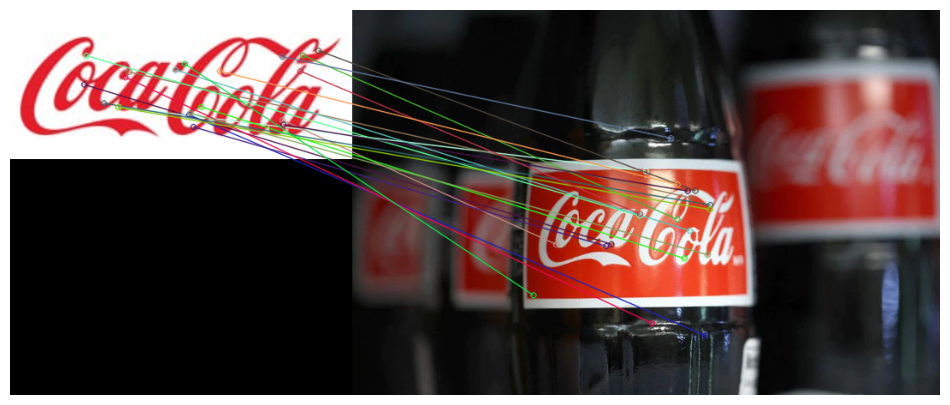

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


In [ ]:
import cv2 as cv
import supervision as sv


img = cv.imread('images/logo_1.png')
template = cv.imread('template/pattern.png')

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

#se crear el detector ORB
orb = cv.ORB_create(nfeatures=1000)

#se detectan keypoints y descriptores
kp1, des1 = orb.detectAndCompute(template_gray, None)
kp2, des2 = orb.detectAndCompute(img_gray, None)

#Cremos el objeto BFMatcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

#Se ordenan los matches por distancia
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar los mejores 20 matches
img_matches = cv.drawMatches(template, kp1, img, kp2, matches[:20], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#Graficamos las coincidencias
sv.plot_image(img_matches)
print(f"Se detectaron {len(matches)} coincidencias ORB.")

los mejores 20 ORB Matches:


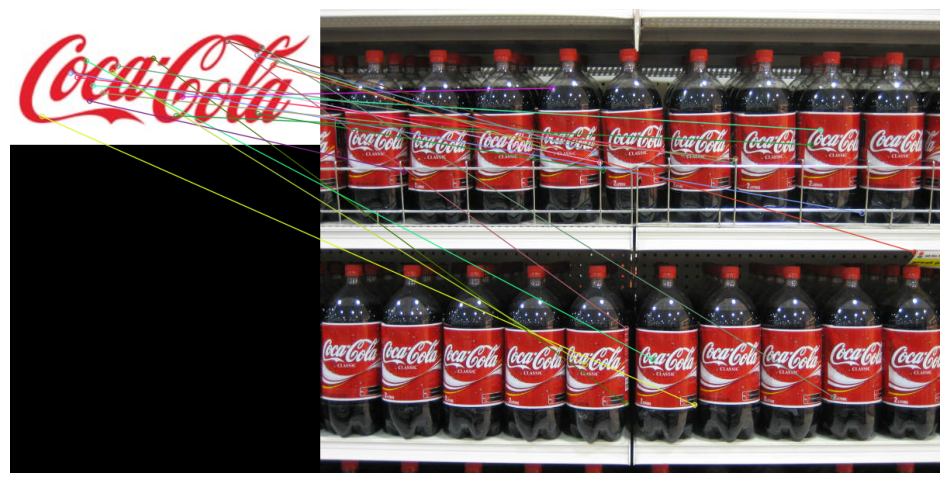

los Keypoint Matches sobre Image:


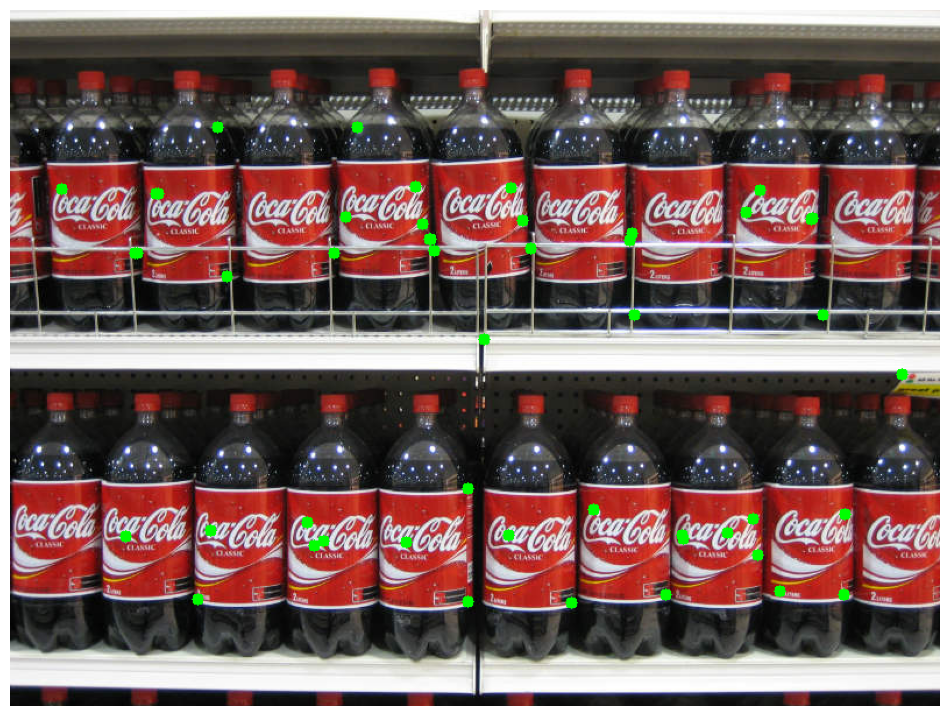

>>> detectadas: 0


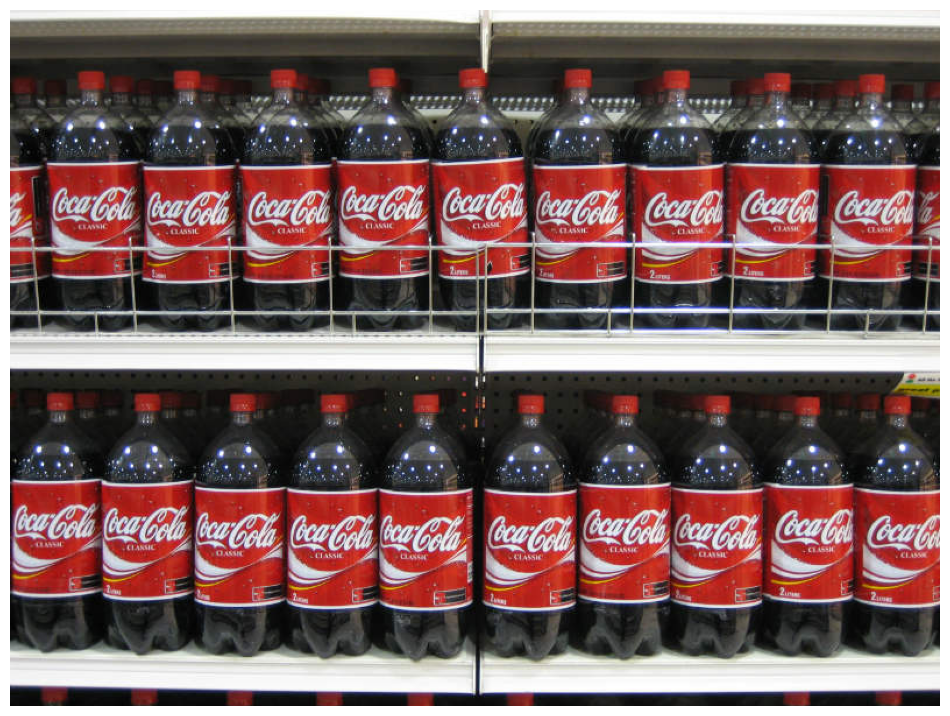

In [30]:
import cv2 as cv
import numpy as np
import supervision as sv


tpl_path = 'template/pattern.png'
img_path = 'images/coca_multi.png'
template = cv.imread(tpl_path)
img      = cv.imread(img_path)


tpl_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
img_gray = cv.cvtColor(img,      cv.COLOR_BGR2GRAY)

#se crear el detector ORB
orb = cv.ORB_create(nfeatures=2000)
kp1, des1 = orb.detectAndCompute(tpl_gray, None)
kp2, des2 = orb.detectAndCompute(img_gray, None)


bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = sorted(bf.match(des1, des2), key=lambda m: m.distance)

# Grafico los mejores 20 matches
img_matches = cv.drawMatches(
    template, kp1,
    img,      kp2,
    matches[:20],
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
print("los mejores 20 ORB Matches:")
sv.plot_image(img_matches)

#Marcar keypoints en la imagen con multiples logos
img_kp = img.copy()
for m in matches[:50]:
    x, y = kp2[m.trainIdx].pt
    cv.circle(img_kp, (int(x), int(y)), 5, (0,255,0), -1)

print("los Keypoint Matches sobre Image:")
sv.plot_image(img_kp)

# extraer las detecciones con homografía
h, w = tpl_gray.shape
corners = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)

def extract_instance(matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    if M is None or mask.sum() < 10:
        return None, None
    pts = cv.perspectiveTransform(corners, M)
    inliers = [i for i, v in enumerate(mask.ravel()) if v]
    return np.int32(pts), inliers

img_out = img.copy()
remaining = matches.copy()
instances = 0

while True:
    res = extract_instance(remaining)
    if res[0] is None:
        break
    poly, inliers = res
    cv.polylines(img_out, [poly], True, (0,255,0), 3, cv.LINE_AA)
    instances += 1
    remaining = [m for i,m in enumerate(remaining) if i not in inliers]

print(f">>> detectadas: {instances}")
sv.plot_image(img_out)



